### Imports

In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import spectral_norm as SN
from torchvision.transforms import Normalize
from torchvision.models import vgg19, mobilenet_v2
import torch.nn.functional as F
from torch.optim import Adam, AdamW
import torch.nn as nn
import torch
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from PIL import Image # load 'em image files
from tqdm import tqdm # progress bar
import numpy as np # linear algebra
import random
import wandb
import time
import glob # getting complete input filepaths for building the dataset 
import os # basic file navigation
from functools import partial

N_CORES = cpu_count()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ['WANDB_API_KEY'] = user_secrets.get_secret("wab_key")

USE_WANDB = True
RUN_SWEEP = True
os.environ['WANDB_SILENT'] = 'True' # make wandb not spit out output for every sweep run
WANDB_PROJECT = 'mongoly_sweep'
if USE_WANDB and not RUN_SWEEP:
    wandb.init(project=WANDB_PROJECT, name='torch_base_config_bs32')

### Hyperparameters

In [2]:
TRAIN_GAN = False
PRETRAINED_MODEL = False
PRETRAINED_GAN = False
BATCH_SIZE = 32
CROPS_PER_IMG = 1
EPOCHS = 50
CV_RATIO = 0.8 # proportion of the full dataset reserved for training, the rest is validation
FULL_IMG_SIZE = (720, 1280) # size of the input images as well as the images that we want to test our model's speed on
IMG_SIZE = (256, 256) # the size of the images used during training; we will take random crops of the full-sized (720p) imagees
DEG_DIR = '/kaggle/input/video-frame-restoration/deg' # parent path of the degraded input images
GT_DIR = '/kaggle/input/video-frame-restoration/gt' # parent path of the ground truth (GT) images

# sweep hyperparameters
MAX_DOWNSAMPLES = 4
MAX_NF = 1024
MAX_PARAMS = 2e6
TARGET_FPS = 100
FPS_VARIATION = 0.75

### Sweep Config

In [5]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'   
    },
    
    #'early_terminate': {
    #  'type': 'hyperband',
    #  'min_iter': 3
    #},
    
    'parameters': {
        'crops_per_img': {
            'value': 2
            #'values': [0, 1, 2, 3]
        },
        'center_grad': { 'value': False },
        
        'base_nf': {
            'values': [8, 16]
        },
        #
        #'num_up_mults': { 'values': [i for i in range(MAX_DOWNSAMPLES+1)]},
        #**{f'up_mult_{i}': { 'values': [1, 2, 4] } for i in range(MAX_DOWNSAMPLES)},
        
        'num_middle_blocks': {
            'min': 0,
            'max': 3
        },
        
        'num_down_blocks': {
            'min': 0,
            'max': 3
        },
        
        'num_up_blocks': {
            'min': 0,
            'max': 3
        },
        #'base_nf': { 'value': 8 },
        'num_up_mults': { 'value': 2 },
        **{f'up_mult_{i}': { 'value': 4 } for i in range(2)},
        #'num_middle_blocks': { 'value': 0 },
        #'num_down_blocks': { 'value': 0 },
        #'num_up_blocks': { 'value': 1 },
        
        'rgb_aug_prob': { 'value': 0.0 },
        'cutblur_alpha': { 'value': 0.7 },
        'cutblur_square_gt_prob': { 'value': 0.5 },
        'cutblur_aug_prob': { 'value': 0.0 },
        
        'lr': {
            #'distribution': 'log_uniform',
            #'min': float(np.log(3e-4)),
            #'max': float(np.log(3e-3))
            'value': 5e-4
        },
        'weight_decay': {
            #'distribution': 'log_uniform',
            #'min': float(np.log(1e-5)),
            #'max': float(np.log(1e-3))
            'value': 0
        },
        'batch_size': {
            #'min': 3,
            #'max': 6
            'value': 5,
        }
    },
}

### Get File Paths For Dataset

In [6]:
# get all of the input images
# 1st * = get folders with h264 and vp9 compression
# 2nd * = get folders from all compression qualities
# 3rd * = get all files from the folders collected from the 1st and 2nd stars
input_img_paths = sorted(glob.glob(f'{DEG_DIR}/*/*/*'))

# get all of the output images
target_img_paths = sorted(glob.glob(f'{GT_DIR}/*'))

m = len(target_img_paths) # the "true" number of unique images in the dataset (the input data contains a multiple of this amount)
num_copies = len(input_img_paths) // m # returns the number of compression types and scales were used to synthesize the input data from the target data

for i in range(10): # list first 10 input/target file paths
    print(f'Input image path: {input_img_paths[i]} | Target image path: {target_img_paths[i]}')
    
print("Number of input images:", len(input_img_paths))
print("Number of target images:", len(target_img_paths))

Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00001.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00000.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00002.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00001.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00003.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00002.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00004.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00003.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00005.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00004.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00006.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00005.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00007.jpg |

### View Some Input Images

In [7]:
train_input_paths = []
val_input_paths = []

'''
The input dataset looks like this:
X: [h264_crf_39_images][h264_crf_45_images]...[vp9_crf_63_images] (each [section] of images is length m)
y: [gt_images]

I want to split up the input dataset like this:
X (train): [h264_crf_39_train][h264_crf_45_train]...[vp9_crf_63_train]
X (valid): [h264_crf_39_valid][h264_crf_45_valid]...[vp9_crf_63_valid]
y (train): [gt_images_train] x6 (replicated for each compression type in the input data)
y (valid): [gt_images_valid] x6
'''

# Shuffle the input and GT frames so the frames from each video are equally scattered in the dataset index-wise
# before, all of the amsterdam images were at the end of the dataset, causing train/validation dataset discrepancy
input_img_paths_copies = [np.array(input_img_paths[m*copy_idx:m*(copy_idx+1)]) for copy_idx in range(num_copies)] # each element in the list is a dataset copy under one compression style
random_ordering = np.random.permutation(np.arange(m)) # generate an ordering to shuffle each copy in input_img_paths_copies in the same way
input_img_paths = [copy[random_ordering] for copy in input_img_paths_copies] # rearrange each copy
input_img_paths = [path for copy in input_img_paths for path in copy] # unpack each path from each copy
target_img_paths = list(np.array(target_img_paths)[random_ordering]) # convert, then rearrange, then convert again

for i in range(num_copies):
    # get start, end, and split indexes for each [section] of images
    s_i = m * i
    split_i = s_i + int(m * CV_RATIO)
    e_i = s_i + m
    
    # update the train and validation dataset based on the indexes defined above
    train_input_paths += input_img_paths[s_i:split_i]
    val_input_paths += input_img_paths[split_i:e_i]

# split the ground truth images into train/validation
train_gt_paths = target_img_paths[:int(m * CV_RATIO)]
val_gt_paths = target_img_paths[int(m * CV_RATIO):m]

# replicate the target data to be the same size as the training data
train_gt_paths *= num_copies
val_gt_paths *= num_copies
assert len(train_gt_paths) - len(train_input_paths) == len(val_gt_paths) - len(val_input_paths) == 0 # make sure the datasets are the same length

# shuffle the train/validation datasets such that the train and the target data are shuffled together (so an index accesses an input as well as its corresponding output)
zipped_paths = list(zip(train_input_paths, train_gt_paths))
random.shuffle(zipped_paths)
train_input_paths, train_gt_paths = zip(*zipped_paths)

zipped_paths = list(zip(val_input_paths, val_gt_paths))
random.shuffle(zipped_paths)
val_input_paths, val_gt_paths = zip(*zipped_paths)

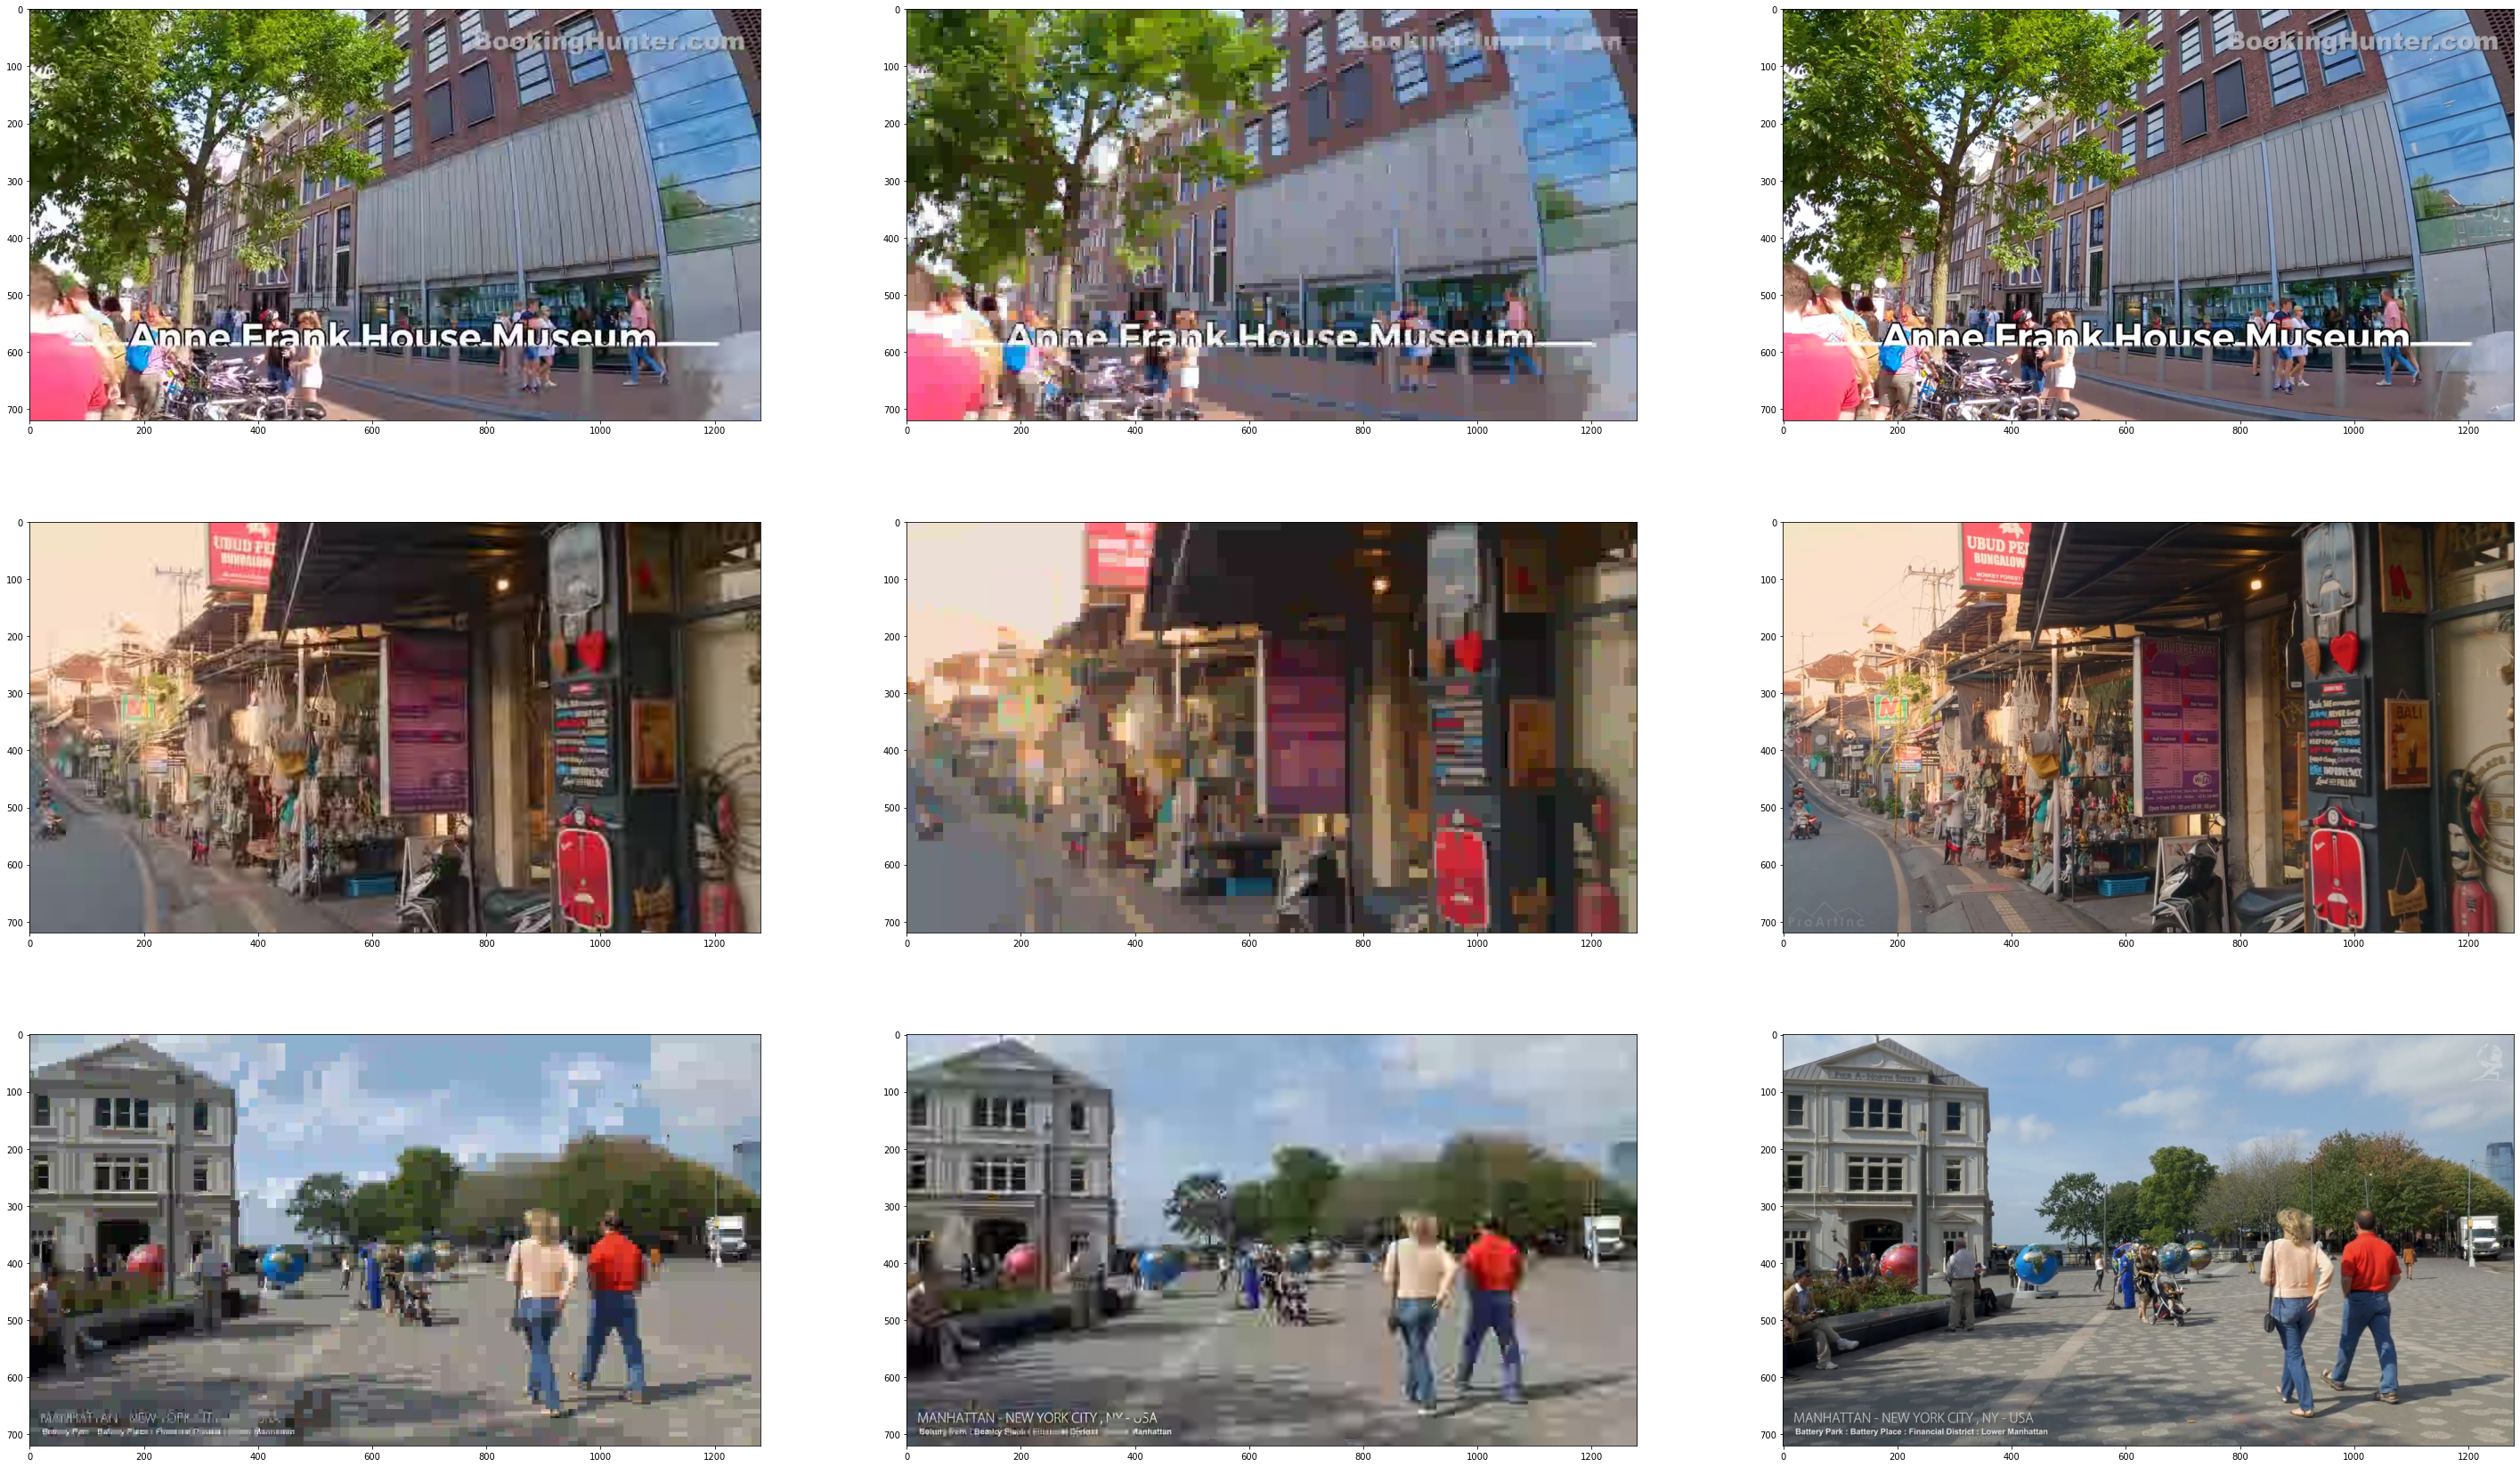

In [8]:
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(50, 30)) # 3 rows and 7 columns of images to be viewed
for row in range(rows):
    seed_image_idx = random.randint(0, m-1) # index of ground truth image which will be displayed
    input_image_idxs = np.random.choice([i for i in range(6)], cols-1, replace=False) # choose cols-1 random augmentations from the 6 made in the dataset
    for col, input_image_idx in enumerate(input_image_idxs): # first 6 columns in each row shows the same input image with different compressions, last column shows the ground truth image
        img = Image.open(input_img_paths[input_image_idx * m + seed_image_idx]) # the way the dataset is formatted allows the same input images to be accessed like this
        axes[row][col].imshow(img)
    gt_img = img = Image.open(target_img_paths[seed_image_idx])
    axes[row][-1].imshow(gt_img)
plt.show()

### Augmentations

In [9]:
# augmentations below take in two np arrays (x, y) and return the augmented (x, y)

def xflip(x, y, prob=1.0):
    if np.random.uniform() >= prob:
        return x, y
    
    if np.random.uniform() < 0.5: # random x flip
        x = x[:, ::-1]
        y = y[:, ::-1]
    return x, y

def rot90(x, y, prob=1.0):
    if np.random.uniform() >= prob:
        return x, y
    
    num_rots = np.random.randint(4)
    return np.rot90(x, num_rots), np.rot90(y, num_rots)

def rgb(x, y, prob=1.0):
    if np.random.uniform() >= prob:
        return x, y
    
    perm = np.random.permutation(3)
    x = x[:, :, perm]
    y = y[:, :, perm]

    return x, y

def cutblur(x, y, alpha=0.7, square_gt_prob=0.5, prob=1.0):
    if np.random.uniform() >= prob:
        return x, y
    cut_ratio = np.random.randn() * 0.01 + alpha
    h, w = y.shape[:-1]
    mask_height, mask_width = np.int(h*cut_ratio), np.int(w*cut_ratio)
    s_y = np.random.randint(0, h-mask_height) # top and left coords
    s_x = np.random.randint(0, w-mask_width)

    if np.random.random() < square_gt_prob: # square mask is GT image
        x[s_y:s_y+mask_height, s_x:s_x+mask_width] = y[s_y:s_y+mask_height, s_x:s_x+mask_width]
    else: # square mask is input image
        y_copy = y.copy()
        y_copy[s_y:s_y+mask_height, s_x:s_x+mask_width] = x[s_y:s_y+mask_height, s_x:s_x+mask_width]
        x = y_copy
        
    return x, y

### Dataset Class

In [10]:
default_transforms = { # aug func: *args
    xflip: (1.0,),
    rot90: (1.0,),
    rgb: (0.0,),
    cutblur: (0.7, 0.5, 0.0),
}

class ImgDataset(Dataset): # seed code by hhttps://keras.io/examples/vision/oxford_pets_image_segmentation/, modified to perform minor data augmentation
    def __init__(self, input_img_paths, target_img_paths, img_size=IMG_SIZE, crops_per_img=CROPS_PER_IMG, transforms=default_transforms):
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.crops_per_img = crops_per_img
        self.transforms = transforms

    def __len__(self):
        return len(self.target_img_paths)

    def __getitem__(self, idx):
        x_path = self.input_img_paths[idx]
        y_path = self.target_img_paths[idx]
        
        x = np.zeros((self.crops_per_img, *self.img_size, 3), np.float32) # return arrays for the input/output images
        y = np.array(x, copy=True)
        
        x_img = np.array(Image.open(x_path))
        y_img = np.array(Image.open(y_path))

        random_crop_y = np.random.uniform(0, FULL_IMG_SIZE[0]-IMG_SIZE[0], (self.crops_per_img,)).astype(np.int32)
        random_crop_x = np.random.uniform(0, FULL_IMG_SIZE[1]-IMG_SIZE[1], (self.crops_per_img,)).astype(np.int32)

        for i, (s_y, s_x) in enumerate(zip(random_crop_y, random_crop_x)): # augment the loaded image crops_per_img times
            cropped_x = x_img[s_y:s_y+IMG_SIZE[0], s_x:s_x+IMG_SIZE[1]]
            cropped_y = y_img[s_y:s_y+IMG_SIZE[0], s_x:s_x+IMG_SIZE[1]]

            for transform in self.transforms:
                cropped_x, cropped_y = transform(cropped_x, cropped_y, *self.transforms[transform])

            x[i] = cropped_x / 255.
            y[i] = cropped_y / 255.
        
        return torch.from_numpy(x.transpose(0, 3, 1, 2)), torch.from_numpy(y.transpose(0, 3, 1, 2))

### Generator architecture

In [11]:
relu = F.relu

class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = nn.Conv2d(nf, nf, 3, padding=1)
        self.conv2 = nn.Conv2d(nf, nf, 3, padding=1)

    def forward(self, inputs):
        return inputs + self.conv2(relu(self.conv1(relu(inputs))))

class Generator(nn.Module):
    def __init__(self, base_nf=8, down_out_f_mult=[4, 4], down_out_f=None, n_middle=0, n_down=0, n_up=1):
        super().__init__()
        if down_out_f is None:
            if len(down_out_f_mult) == 0:
                down_out_f = []
            else:
                down_out_f = [down_out_f_mult[0] * base_nf]
                for mult in down_out_f_mult[1:]:
                    down_out_f.append(down_out_f[-1] * mult)

        down_in_f = [base_nf] + down_out_f[:-1]
        up_out_f = down_in_f[::-1]
        up_in_f = down_out_f[::-1]

        self.initial_conv = nn.Conv2d(3, base_nf, 1)
        self.dcvs = nn.ModuleList([nn.Conv2d(in_f, out_f, 5, stride=2, padding=2) for in_f, out_f in zip(down_in_f, down_out_f)])
        self.down_blocks = nn.ModuleList([nn.Sequential(*[ResBlock(out_f) for _ in range(n_down)]) for out_f in down_out_f])

        middle_nf = base_nf if len(down_out_f) == 0 else down_out_f[-1]
        self.mid_conv = nn.Sequential(*[ResBlock(middle_nf) for _ in range(n_middle)])

        self.ucvs = nn.ModuleList([nn.Conv2d(in_f, out_f, 1) for in_f, out_f in zip(up_in_f, up_out_f)])
        self.up_blocks = nn.ModuleList([nn.Sequential(*[ResBlock(out_f) for _ in range(n_up)]) for out_f in up_out_f])

        self.last_conv = nn.Conv2d(up_out_f[-1], 3, 1)

    def forward(self, inputs):
        x = self.initial_conv(inputs)

        downs = []
        for idx, (dcv, down_block) in enumerate(zip(self.dcvs, self.down_blocks)):
            downs.append(x)
            x = dcv(relu(x))
            x = down_block(relu(x))

        x = self.mid_conv(x)

        for idx, (ucv, up_block) in enumerate(zip(self.ucvs, self.up_blocks)):
            x = F.interpolate(x, scale_factor=2.0)
            x = ucv(x)
            x += downs[-idx-1]
            x = up_block(x)

        outputs = self.last_conv(x)

        return outputs

### Discriminator Architecture

In [12]:
s_lrelu = nn.LeakyReLU(0.2)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial_conv = nn.Conv2d(3, 64, 3, padding='same')
        self.conv1 = SN(nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False))
        self.conv2 = SN(nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False))
        self.conv3 = SN(nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False))
        
        self.conv4 = SN(nn.Conv2d(512, 256, 3, padding='same', bias=False))
        self.conv5 = SN(nn.Conv2d(256, 128, 3, padding='same', bias=False))
        self.conv6 = SN(nn.Conv2d(128, 64, 3, padding='same', bias=False))
        
        self.last_convs = nn.Sequential([
            SN(nn.Conv2d(64, 64, 3, padding='same', bias=False)) for _ in range(2)
        ])
        
        self.final_conv = nn.Conv2d(64, 1, 3, padding='same')
    
    def forward(self, inputs):
        x0 = s_lrelu(self.initial_conv(inputs))
        x1 = s_lrelu(self.conv1(x0))
        x2 = s_lrelu(self.conv2(x1))
        x3 = s_lrelu(self.conv3(x2))

        x3 = F.interpolate(x3, scale_factor=2.0, mode='bilinear')
        x4 = s_lrelu(self.conv4(x3)) + x2
        x4 = F.interpolate(x4, scale_factor=2.0, mode='bilinear')
        x5 = s_lrelu(self.conv5(x4)) + x1
        x5 = F.interpolate(x5, scale_factor=2.0, mode='bilinear')
        x6 = s_lrelu(self.conv6(x5)) + x0

        out = self.last_convs(x6)
        out = self.final_conv(out)

        return out

### VGG Feature Extractor Architecture

In [13]:
vgg_layer_idxs = [2, 7, 16, 25, 34] # corresponds to conv_1_2, conv_2_2, conv_3_4, conv_4_4, conv_5_4
mb_layer_idxs = [1, 3, 6, 13, 17]
mae = nn.L1Loss() # L1 loss = mean absolute error (MAE)

class PerceptualLoss(torch.nn.Module):
    def __init__(self, model=vgg19, layer_idxs=vgg_layer_idxs, act_weights=[1.0, 1.0, 1.0, 1.0, 1.0]):
        super().__init__()
        blocks = []
        model_features = model(pretrained=True).features.eval()
        model_features.apply(self._remove_inplace_activations)
        for p in model_features.parameters():
            p.requires_grad_(False)
            
        for s_i, e_i in zip([-1] + layer_idxs[:-1], layer_idxs):
            blocks.append(model_features[s_i+1:e_i+1])
        self.blocks = torch.nn.ModuleList(blocks)
        
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
        self.act_weights = act_weights
    
    def _remove_inplace_activations(self, module): # bruh default inplace = True caused multiple issues from runtime errors to lack of "before activation" feature maps
        if type(module) in {nn.ReLU, nn.ReLU6}:
            module.inplace = False

    def forward(self, y_pred, y, act_weights=None):
        if act_weights is None:
            act_weights = self.act_weights
            
        x = (y_pred - self.mean) / self.std
        y = (y - self.mean) / self.std
        loss = 0.0
        
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            loss += act_weights[i] * torch.nn.functional.l1_loss(x, y)
            
        return loss

### Generator FPS Test

In [14]:
def test_fps(model, duration=2, warmup_duration=1, verbose=True):
    def vprint(*args):
        if verbose:
            print(*args)
    try:
        test_img = torch.zeros((1, 3, 720, 1280)).to(device)
        out = model(test_img)
        a = time.time()
        vprint('Starting warmup.')
        while time.time() - a < warmup_duration:
            _ = model(test_img)

        a = time.time()
        frames = 0
        vprint('Starting FPS test.')
        while time.time() - a < duration:
            _ = model(test_img)
            frames += 1
        return frames / duration
    except Exception as e:
        pass

### Loss Functions

In [15]:
def gen_loss_fn(y_pred, y_true, percep_weight=1.0, mae_weight=0.01):
    vgg_loss = percep_weight * percep_loss_fn(y_pred, y_true)
    #mae_loss = mae_weight * mae(y_pred, y_true)
    return vgg_loss #+ mae_loss

### Build Datasets and Models

In [16]:
if not RUN_SWEEP:
    train_ds = ImgDataset(train_input_paths, train_gt_paths)
    train_gen = DataLoader(train_ds, batch_size=BATCH_SIZE//CROPS_PER_IMG, shuffle=True, num_workers=N_CORES)
    val_ds = ImgDataset(val_input_paths, val_gt_paths, crops_per_img=1, transforms={})
    val_gen = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_CORES)

In [17]:
if not RUN_SWEEP:
    gen = Generator().to(device)
    gen_opt = Adam(gen.parameters(), 5e-4 * BATCH_SIZE/32)
    print(gen)
#percep_loss_fn = PerceptualLoss().to(device)
percep_loss_fn = PerceptualLoss(model=mobilenet_v2, layer_idxs=mb_layer_idxs).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

### Test Model FPS

In [18]:
# ideally this should run at least 60 FPS to make it run as fast as possible on consumer-grade hardware but sadly it falls short.
# Through some tests, the main factor for the model's inference latency appeared to be the model depth, but the model is already 
# pretty shallow so I'm hesitant to remove some layers to make it faster.
if True and (not TRAIN_GAN) and (not RUN_SWEEP):
    fps = test_fps(gen)
    print(f'Model ran at {fps} FPS')

### Gradient Centralization Func

In [19]:
def center_grad_fn(grads):
    for grad in grads:
        rank = len(grad.shape)
        if rank > 1: # if the weight is not a bias
            grad -= grad.mean([i for i in range(1, rank)], keepdim=True)

### Train Func

In [20]:
def train(gen, train_gen, val_gen, gen_opt, num_epochs=1, steps_per_epoch=None, loss_fn=mae, wandb_log=True, grad_fn=center_grad_fn):
    for epoch in range(num_epochs):
        train_loss = 0.0
        steps_per_epoch = steps_per_epoch if steps_per_epoch is not None else len(train_gen)
        pbar = tqdm(train_gen, total=steps_per_epoch)
        tqdm_string = ''
        for batch_idx, (x, y) in enumerate(pbar):
            b1, b2, c, h, w = x.shape
            x = x.view(b1*b2, c, h, w)
            y = y.view(b1*b2, c, h, w)
            x, y = x.to(device), y.to(device)
            gen_opt.zero_grad()
            y_pred = gen(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            if grad_fn is not None:
                grad_fn([param.grad for param in gen.parameters()])
            gen_opt.step()
            
            train_loss += loss.item()
            tqdm_string = f'Epoch {epoch}, Train loss: {loss.item()}'
            pbar.set_description(tqdm_string)
            
            if batch_idx >= steps_per_epoch:
                break
        
        val_loss = 0.0
        with torch.no_grad():
            num_val_steps = int(steps_per_epoch * (1 - CV_RATIO))
                
            for batch_idx, (x, y) in enumerate(val_gen):
                b1, b2, c, h, w = x.shape
                x = x.view(b1*b2, c, h, w)
                y = y.view(b1*b2, c, h, w)
                x, y = x.to(device), y.to(device)
                y_pred = gen(x)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
                
                if batch_idx >= num_val_steps:
                    break
        
        print('Validation loss:', val_loss / num_val_steps)
        if USE_WANDB and wandb_log:
            wandb.log({
                'loss': train_loss / steps_per_epoch,
                'val_loss': val_loss / num_val_steps,
            })

### Predict Validation Image Func

In [21]:
def show_prediction(gen, val_ds, n_imgs=1, show_img=True, fname='temp.png', wandb_log=True, log_title='prediction'):
    fig, axes = plt.subplots(n_imgs, 3, figsize=(20, 7*n_imgs))
    for i in range(n_imgs):
        test_deg_img, test_gt_img = random.choice(val_ds)
        test_deg_img, test_gt_img = test_deg_img.to(device), test_gt_img.to(device)
        with torch.no_grad():
            pred = gen(test_deg_img)
        
        if n_imgs == 1:
            ax = axes
        else:
            ax = axes[i]
        
        if i == 0:
            ax[0].set_title('Input')
            ax[1].set_title('Model Prediction')
            ax[2].set_title('Ground Truth')
            
        ax[0].imshow(test_deg_img.cpu().numpy()[0].transpose(1, 2, 0))
        ax[1].imshow(pred.cpu().numpy()[0].transpose(1, 2, 0))
        ax[2].imshow(test_gt_img.cpu().numpy()[0].transpose(1, 2, 0))
        
    savedir = f'/kaggle/working/{fname}'
    plt.savefig(savedir)
    if USE_WANDB and wandb_log:
        log_img = wandb.Image(savedir)
        wandb.log({log_title: log_img})
    if show_img:
        plt.show()

### Sweep Run Func

In [22]:
def run_sweep():
    torch.cuda.empty_cache()
    run_id = ''.join(random.choices('1234567890', k=9))
    with wandb.init(name=f'sweep_run_{run_id}') as run:
        config = wandb.config
        base_nf = config['base_nf']
        down_out_f_mult = [config[f'up_mult_{i}'] for i in range(config['num_up_mults'])]
        num_middle_blocks = config['num_middle_blocks']
        num_down_blocks = config['num_down_blocks']
        num_up_blocks = config['num_up_blocks']
        
        if np.prod(down_out_f_mult) * base_nf > MAX_NF:
            print(f'Model config contains layer with too many channels (max channels={MAX_NF}, config contains {np.prod(down_out_f_mult) * base_nf}). Skipping...')
            run.finish(-1)
            return

        gen = Generator(base_nf, down_out_f_mult, n_middle=num_middle_blocks, n_down=num_down_blocks, n_up=num_up_blocks)
        nparams = sum(p.numel() for p in gen.parameters())
        
        if nparams >= MAX_PARAMS:
            print(f'Model config contains too many parameters (max param count={MAX_PARAMS}, number of model params={nparams}). Skipping...')
            run.finish(-1)
            return
        
        gen = gen.to(device)
        fps = test_fps(gen, verbose=False)
        if fps is None or not (1-FPS_VARIATION < fps/TARGET_FPS < 1+FPS_VARIATION):
            print(f'Model config is too slow/fast (target fps={TARGET_FPS}, model fps={fps}). Skipping...')
            run.finish(-1)
            return
        
        batch_size = int(2**config['batch_size'])
        crops_per_img = int(2**config['crops_per_img'])
        #time_multiplier = (crops_per_img * 4/21 + 17/21) * batch_size / 32 # empirical increase in time for different values of crops_per_img and batch_size
        crops_per_img_slowdown = 8/13 * np.exp(-1.124 * (crops_per_img - 1)) + 5/13 # empirical ratio in time by increasing crops_per_img 
        time_multiplier = batch_size / 32 * crops_per_img_slowdown # empirical increase in time for different values of crops_per_img and batch_size
        
        
        config_transforms = default_transforms.copy()
        config_transforms[rgb] = (config['rgb_aug_prob'],)
        config_transforms[cutblur] = (config['cutblur_alpha'], config['cutblur_square_gt_prob'], config['cutblur_aug_prob'])
        
        train_ds = ImgDataset(train_input_paths, train_gt_paths, crops_per_img=crops_per_img, transforms=config_transforms)
        train_gen = DataLoader(train_ds, batch_size=batch_size//crops_per_img, shuffle=True, num_workers=N_CORES)
        val_ds = ImgDataset(val_input_paths, val_gt_paths, crops_per_img=1, transforms={})
        val_gen = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=N_CORES)
        
        gen_opt = AdamW(gen.parameters(), config['lr']/32*batch_size, weight_decay=config['weight_decay'])
        
        grad_fn = None
        if config['center_grad']:
            grad_fn = center_grad_fn
            
        train(gen, train_gen, val_gen, gen_opt, num_epochs=10, steps_per_epoch=int(250/time_multiplier), loss_fn=gen_loss_fn, grad_fn=grad_fn)
        show_prediction(gen, val_ds, show_img=False, n_imgs=3)

### Train the Model

In [24]:
if RUN_SWEEP:
    #sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)
    sweep_id = '44oc1ha3'
    wandb.agent(sweep_id, run_sweep, project=WANDB_PROJECT)
else:
    show_prediction(gen, val_ds)
    #train(gen, train_gen, val_gen, gen_opt, steps_per_epoch=5000, loss_fn=mae, wandb_log=False)
    for epoch in range(EPOCHS):
        show_prediction(gen, val_ds)
        #train(gen, train_gen, val_gen, gen_opt, steps_per_epoch=2500, loss_fn=gen_loss_fn)
        train(gen, train_gen, val_gen, gen_opt, steps_per_epoch=int(500*32/BATCH_SIZE), loss_fn=gen_loss_fn)

Create sweep with ID: 44oc1ha3
Sweep URL: https://wandb.ai/tiewa_enguin/mongoly_sweep/sweeps/44oc1ha3
Model config is too slow/fast (target fps=100, model fps=2.0). Skipping...


### Generator Prediction Visualization

In [ ]:
if not RUN_SWEEP:
    show_prediction(gen, val_ds, n_imgs=3, log_title='final_prediction')

### Save Models